In [1]:
import os
from pathlib import Path
from typing import List

import openmm.unit as openmm_unit
import parmed
from openff.toolkit.topology import Molecule
from paprika.build.system.fragmenter import CyclodextrinFragmenter
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
IPythonConsole.molSize = (400, 400)
IPythonConsole.ipython_useSVG = True

## Cyclodextrin Dimer Molecule

In [3]:
cwd = Path().resolve()
dimer_1_sdf = os.path.abspath(
    os.path.join(cwd, "../../paprika/data/fragments/dimer-1.sdf")
)

In [4]:
mol = Molecule.from_file(dimer_1_sdf)
mol.generate_unique_atom_names()

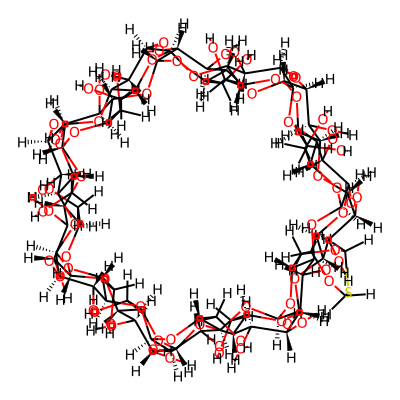

In [5]:
input_mol = mol.to_rdkit()
input_mol

## Glucose Monomer

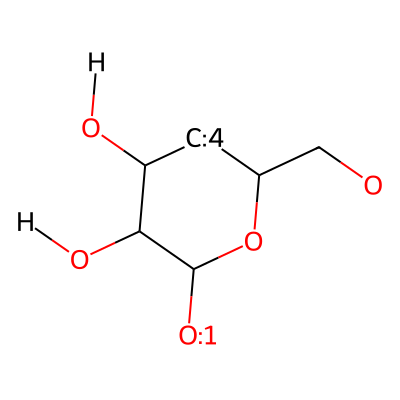

In [6]:
fragment_pure = "[#6]1(-[#8:1])-[#6](-[#8]-[#1])-[#6](-[#8]-[#1])-[#6$([#6]-[#8]):4]-[#6](-[#6]-[#8])-[#8]-1"

glucose_monomer = Chem.MolFromSmarts(fragment_pure)
glucose_monomer

## Thiol linker

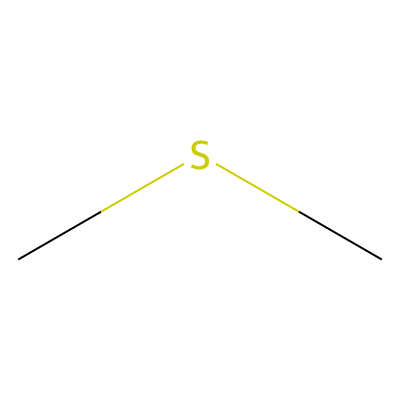

In [7]:
fragment_thiol = "[#6]-[#16]-[#6]"

thiol = Chem.MolFromSmarts(fragment_thiol)
thiol

## Create dimer linker

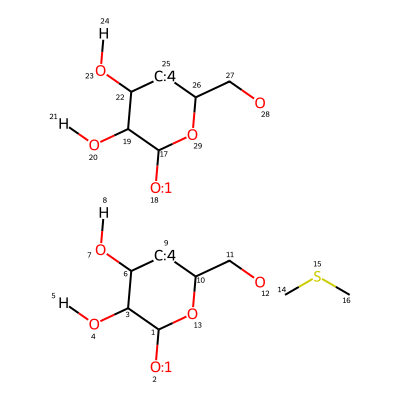

In [8]:
# Combine all three components
combined = Chem.CombineMols(Chem.CombineMols(glucose_monomer, thiol), glucose_monomer)

# Add labels on atoms
for i, atom in enumerate(combined.GetAtoms()):
    atom.SetProp("atomNote", str(atom.GetIdx() + 1))

combined

In [9]:
# Get atomic indices of interface atoms
oxygen_1 = None
oxygen_2 = None
carbon_thiol_1 = None
carbon_thiol_2 = None
for i, atom in enumerate(combined.GetAtoms()):
    index = int(atom.GetProp("atomNote")) + 1

    # O6 of first monomer
    if index == 12:
        oxygen_1 = index - 1

    # 1st Carbon atom to be linked
    elif index == 14:
        carbon_thiol_1 = index - 1

    # O6 of second monomer
    elif index == 16:
        oxygen_2 = index - 1

    # 2nd Carbon atom to be linked
    elif index == 28:
        carbon_thiol_2 = index - 1

# Make molecule editable
edcombo = Chem.EditableMol(combined)

# Add bonds between the three components
edcombo.AddBond(oxygen_1, carbon_thiol_1, order=Chem.BondType.SINGLE)
edcombo.AddBond(oxygen_2, carbon_thiol_2, order=Chem.BondType.SINGLE)

30

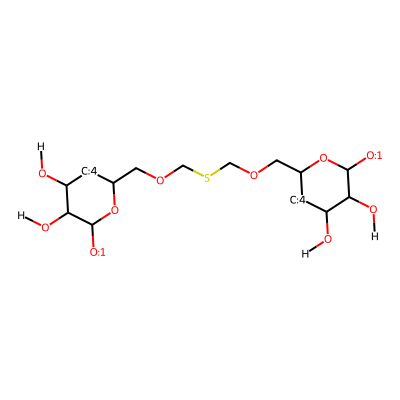

In [10]:
# Transfer Editable back to Chem.Mol
dimer_linker = edcombo.GetMol()
for i, atom in enumerate(dimer_linker.GetAtoms()):
    atom.ClearProp("atomNote")

dimer_linker

## Assign Partial Charges

In [11]:
cyclodextrin = CyclodextrinFragmenter(input_mol)
cyclodextrin.add_monomer(glucose_monomer)
cyclodextrin.add_monomer(dimer_linker)

In [12]:
cyclodextrin.assign_partial_charges(partial_charge_method="am1bcc")

In [13]:
cyclodextrin.to_file("dimer-1.am1bcc.sdf", file_format="SDF")
cyclodextrin.to_file("dimer-1.am1bcc.mol2", file_format="MOL2")
cyclodextrin.to_file("dimer-1.am1bcc.pdb", file_format="PDB")